In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

In [3]:
#pick up the 1st image to have a look   
path_now = path[0]
a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))

In [4]:
a.shape

(8,)

In [5]:
a[0].dtype.names

('objID', 'image', 'class', 'z')

In [6]:
a[0]['objID']

1237658422486696060

In [7]:
a[0]['image'].shape

(5, 64, 64)

In [8]:
a[0]['class']

'GALAXY'

In [9]:
a[0]['z']

0.098008968

In [10]:
Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

In [11]:
print(np.shape(Obj_ID))
print(np.shape(Image))
print(np.shape(Class))
print(np.shape(Redshift))

(14142,)
(14142, 5, 64, 64)
(14142,)
(14142,)


# Here I have 14142 samples with their 
#### Obj_ID = string
#### Image = (5,64,64)
#### Class = star / galaxy
#### Redshift = redshift of the object

In [12]:
Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [13]:
print("Stars; label = 0:",Class[Class == 0].shape)
print("Galaxies; label = 1:",Class[Class == 1].shape)
print("Quasars; label = 2:",Class[Class == 2].shape)

Stars; label = 0: (3587,)
Galaxies; label = 1: (9596,)
Quasars; label = 2: (959,)


In [14]:
Image.shape

(14142, 5, 64, 64)

In [15]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


In [16]:
Image_RGB.shape

(14142, 64, 64, 3)

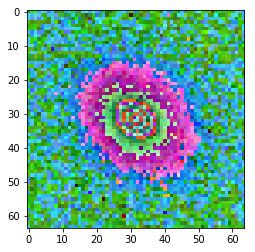

In [17]:
plt.imshow(Image_RGB[3])
plt.show()

In [18]:
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=0

815


In [19]:
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

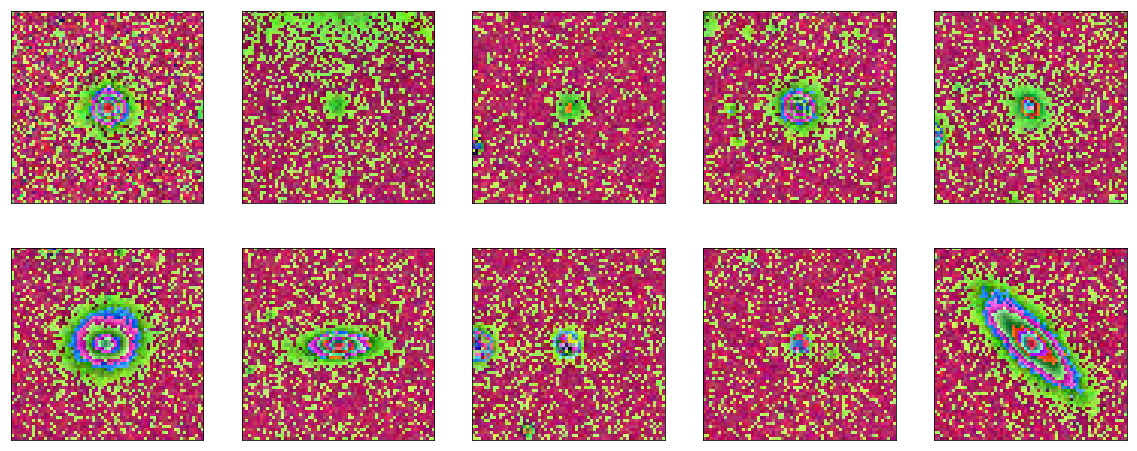

[1 1 1 1 1 1 1 0 2 1]


In [20]:
n=5
plt.figure(figsize=(20, 20*2/5))
for l in range(2):
    for i in range(n):
        ax = plt.subplot(2,n,l*n+i+1)
        plt.imshow((Image_RGB[10+l*5+i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
print(Class[10:20])

# what's the difference between class 0 and class 1? @_@??

In [21]:
import pandas as pd
import numpy as np
from PIL import Image
#import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [22]:
label = np_utils.to_categorical(Class, 3)

In [23]:
data = Image_RGB

In [24]:
train_data = data
train_label = label
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print(train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)
14142  samples


In [132]:
model = Sequential()

model.add(Conv2D(10,(3,3),padding='same',input_shape=(64,64,3),activation='relu',data_format='channels_last'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(20,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(40,(3,3),padding='same',activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Dropout(0.25))

#model.add(BatchNormalization())
model.add(Conv2D(40,(3,3),padding='same',activation='relu'))
model.add(MaxPooling2D((2,2),padding='same'))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))


model.add(Dense(3))
model.add(Activation('sigmoid'))


adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0000001)
sgd = SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True)
#tensorboard = TensorBoard(log_dir='./logs/run_BN', histogram_freq=0)
#checkpoint = ModelCheckpoint('.h5',monitor = 'val_acc',verbose = 1,save_best_only = True)
EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

model.compile(loss='categorical_crossentropy', 
              optimizer=adam,
              metrics=['accuracy'])



model.fit(train_data, train_label, 
          batch_size=50, 
          nb_epoch=300,
          shuffle=True,
          verbose=1,
          validation_split=0.2, 
          callbacks=[EarlyStopping])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/keras/models.py:826: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 11313 samples, validate on 2829 samples
Epoch 1/300
11313/11313 [==============================] - 6s - loss: 0.7086 - acc: 0.6777 - val_loss: 0.7664 - val_acc: 0.6911
Epoch 2/300
11313/11313 [==============================] - 5s - loss: 0.4898 - acc: 0.8222 - val_loss: 0.5195 - val_acc: 0.81440.8
Epoch 3/300
11313/11313 [==============================] - 5s - loss: 0.3578 - acc: 0.8796 - val_loss: 0.3688 - val_acc: 0.8678
Epoch 4/300
11313/11313 [==============================] - 5s - loss: 0.3251 - acc: 0.8884 - val_loss: 0.3304 - val_acc: 0.8848
Epoch 5/300
11313/11313 [==============================] - 5s - loss: 0.3128 - acc: 0.8915 - val_loss: 0.3270 - val_acc: 0.8858
Epoch 6/300
11313/11313 [==============================] - 5s - loss: 0.3020 - acc: 0.8949 - val_loss: 0.3205 - val_acc: 0.8798
Epoch 7/300
11313/11313 [==============================] - 5s - loss: 0.2944 - acc: 0.8952 - val_loss: 0.3240 - val_acc: 0.8819
Epoch 8/300
11313/11313 [===========================

### Results for classification task

accuracy of 90%, may be we can get better result by using other hyperparameters

# Task two: Unsupervised clustering
# 2.1 with 2 hidden units


In [29]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.mean_squared_error(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [30]:
if USE == 'vae':
    vae.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=10,    
            batch_size=batch_size,  
            validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,
            epochs=nb_epoch,  
            batch_size=200,  
            validation_data=(train_data[8000:9000],train_data[8000:9000]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 500 samples
Epoch 1/10
8000/8000 [==============================] - 12s - loss: -7293.5492 - val_loss: -7857.7284
Epoch 2/10
8000/8000 [==============================] - 11s - loss: -7882.7196 - val_loss: -7912.8618
Epoch 3/10
8000/8000 [==============================] - 11s - loss: -7938.1860 - val_loss: -7922.8635
Epoch 4/10
8000/8000 [==============================] - 11s - loss: -7962.4513 - val_loss: -7922.2199
Epoch 5/10
8000/8000 [==============================] - 11s - loss: -7980.7140 - val_loss: -7921.8618
Epoch 6/10
8000/8000 [==============================] - 11s - loss: -7986.5093 - val_loss: -7960.7606
Epoch 7/10
8000/8000 [==============================] - 11s - loss: -8003.8820 - val_loss: -7906.3553
Epoch 8/10
8000/8000 [==============================] - 11s - loss: -8027.3456 - val_loss: -7934.6690
Epoch 9/10
8000/8000 [==============================] - 11s - loss: -8014.3368 - val_loss: -7864.5404
Epoch 10/10
8000/8000 [============

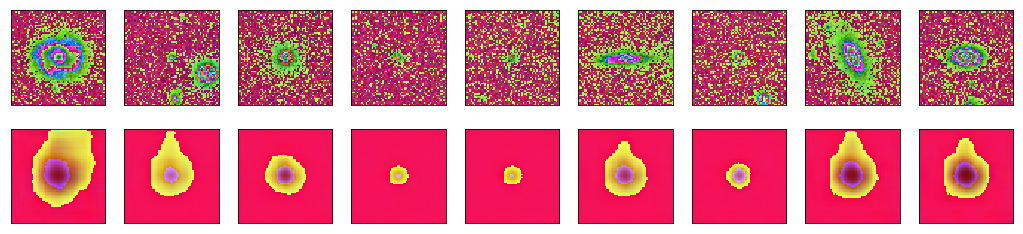

In [31]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
if USE == 'vae':
    decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

if USE == 'autoencoder':
    decoded_imgs = autoencoder.predict(train_data[8000:9000],batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

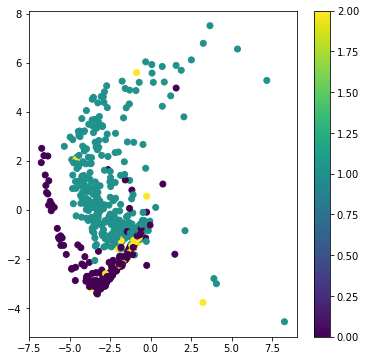

In [32]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9000], batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.show()

# 2.2 with 3 hidden units

In [42]:
batch_size =100
latent_dim = 3
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 64*64

#USE = 'autoencoder'
USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [43]:
if USE == 'vae':
    vae.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=10,    
            batch_size=batch_size,  
            validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=nb_epoch,  
            batch_size=200,  
            validation_data=(train_data[8000:9000],train_data[8000:9000]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 500 samples
Epoch 1/10
8000/8000 [==============================] - 13s - loss: -7200.6330 - val_loss: -7530.1404
Epoch 2/10
8000/8000 [==============================] - 11s - loss: -7732.8862 - val_loss: -7872.1739
Epoch 3/10
8000/8000 [==============================] - 11s - loss: -7923.8678 - val_loss: -7901.6496
Epoch 4/10
8000/8000 [==============================] - 11s - loss: -7931.4879 - val_loss: -7963.8852
Epoch 5/10
8000/8000 [==============================] - 11s - loss: -7989.8034 - val_loss: -7983.4310
Epoch 6/10
8000/8000 [==============================] - 11s - loss: -7971.2809 - val_loss: -7868.1879
Epoch 7/10
8000/8000 [==============================] - 11s - loss: -8024.8708 - val_loss: -7967.0405
Epoch 8/10
8000/8000 [==============================] - 11s - loss: -8036.3716 - val_loss: -7964.5317
Epoch 9/10
8000/8000 [==============================] - 11s - loss: -8000.7591 - val_loss: -7973.4877
Epoch 10/10
8000/8000 [============

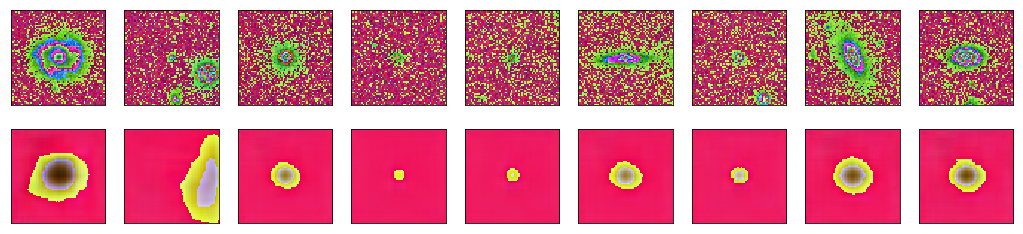

In [46]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
if USE == 'vae':
    decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

if USE == 'autoencoder':
    decoded_imgs = autoencoder.predict(train_data[8000:9000],batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

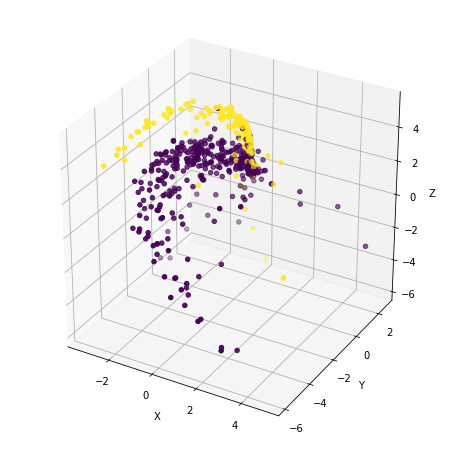

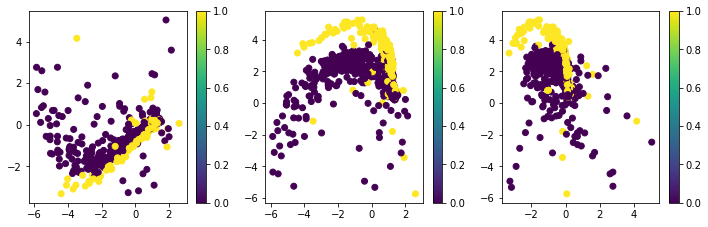

In [45]:
from mpl_toolkits.mplot3d import Axes3D
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =train_label[i,0]
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9000], batch_size=batch_size)  
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax.scatter( x_vis[:, 1] ,x_vis[:, 0], x_vis[:, 2],c=label_value[8000:9000])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(3,3,1)
plt.scatter(x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.subplot(3,3,2)
plt.scatter(x_vis[:, 0] ,x_vis[:, 2],c=label_value[8000:9000])
plt.colorbar()
plt.subplot(3,3,3)
plt.scatter(x_vis[:, 1] ,x_vis[:, 2],c=label_value[8000:9000])
plt.colorbar()
plt.show()

## Left: vertical view ;            Mid: front view;               Right: side view
# 2.3 Autoencoder: 2 hidden units

In [37]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim =256
original_dim = 64*64

USE = 'autoencoder'
#USE = 'vae'
#encoder:

input_img = Input(shape=(64,64,3))


x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = MaxPooling2D((2, 2),  padding='same')(x)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(x)
h_1 = Dense(intermediate_dim, activation='tanh')(visual)
encoded = Dense(latent_dim, activation='relu')(h_1)

z_mean = Dense(latent_dim)(h_1)
z_log_var = Dense(latent_dim)(h_1)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

if USE == 'vae':
    h_3 = Dense(intermediate_dim,activation='tanh')(z)#for VAE

if USE == 'autoencoder':
    h_3 = Dense(intermediate_dim,activation='tanh')(encoded)#for AE
    
    
h_4 = Dense(20*2*2,activation='relu')(h_3)
h_5 = Reshape((2,2,20))(h_4)


x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_5)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(80,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  

def ae_loss(x, decoded):  
    xent_loss = original_dim * objectives.binary_crossentropy(x,decoded)
    return xent_loss

if USE == 'autoencoder':
    autoencoder = Model(inputs=input_img, outputs=decoded)
    autoencoder.compile(optimizer='rmsprop', loss=ae_loss)
if USE == 'vae':
    vae = Model(inputs=input_img, outputs=decoded) 
    vae.compile(optimizer='rmsprop', loss=vae_loss) 

In [38]:
if USE == 'vae':
    vae.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=10,    
            batch_size=10,  
            validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

if USE == 'autoencoder':
    autoencoder.fit(train_data[:8000], train_data[:8000],  
            shuffle=True,  
            epochs=10,  
            batch_size=200,  
            validation_data=(train_data[8000:9000],train_data[8000:9000]),callbacks=[EarlyStopping])

Train on 8000 samples, validate on 1000 samples
Epoch 1/10
8000/8000 [==============================] - 14s - loss: -6029.7731 - val_loss: -6460.0755
Epoch 2/10
8000/8000 [==============================] - 11s - loss: -6587.6915 - val_loss: -6585.9845
Epoch 3/10
8000/8000 [==============================] - 11s - loss: -6657.0320 - val_loss: -6586.0616
Epoch 4/10
8000/8000 [==============================] - 11s - loss: -7298.9104 - val_loss: -7481.7848
Epoch 5/10
8000/8000 [==============================] - 11s - loss: -7591.4369 - val_loss: -7608.2995
Epoch 6/10
8000/8000 [==============================] - 11s - loss: -7638.8949 - val_loss: -7597.7548
Epoch 7/10
8000/8000 [==============================] - 11s - loss: -7626.2020 - val_loss: -7606.0195
Epoch 8/10
8000/8000 [==============================] - 11s - loss: -7651.9254 - val_loss: -7303.1536
Epoch 9/10
8000/8000 [==============================] - 11s - loss: -7644.8903 - val_loss: -7615.8341
Epoch 10/10
8000/8000 [===========

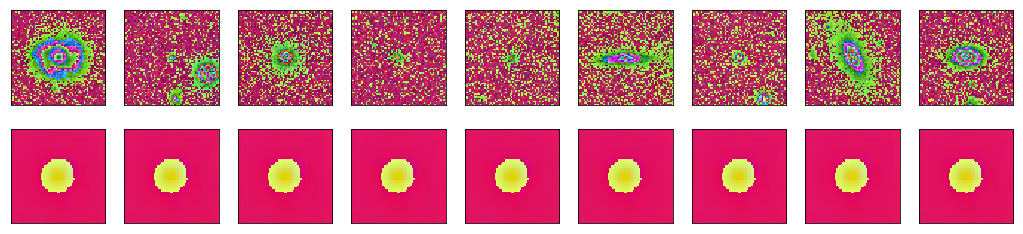

In [39]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)
if USE == 'vae':
    decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

if USE == 'autoencoder':
    decoded_imgs = autoencoder.predict(train_data[8000:9000],batch_size=100)


n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

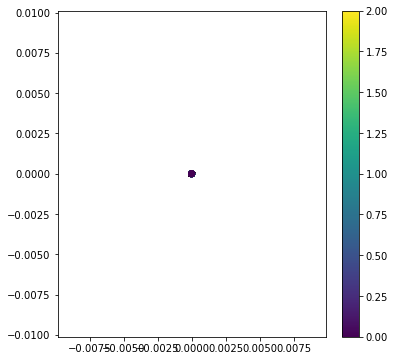

In [40]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])
if USE == 'autoencoder':
    vis = Model(input_img, encoded)
if USE == 'vae':
    vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9000], batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.show()